In [ ]:
https://zhuanlan.zhihu.com/p/62031783


In [2]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import quad
mpl.rcParams['font.family'] = 'serif'

In [3]:
#BSM模型定价
def dN(x):
    ''' Probability density function of standard normal random variable x. '''
    return math.exp(-0.5 * x ** 2) / math.sqrt(2 * math.pi)

def N(d):
    ''' Cumulative density function of standard normal random variable x. '''
    return quad(lambda x: dN(x), -20, d, limit=50)[0]

def d1f(St, K, t, T, r, sigma):
    ''' Black-Scholes-Merton d1 function.
        Parameters see e.g. BSM_call_value function. '''
    d1 = (math.log(St / K) + (r + 0.5 * sigma ** 2)
          * (T - t)) / (sigma * math.sqrt(T - t))
    return d1

#
# Valuation Functions
#
def BSM_call_value(St, K, t, T, r, sigma):
    ''' Calculates Black-Scholes-Merton European call option value.
    Parameters
    ==========
    St : float
        stock/index level at time t
    K : float
        strike price
    t : float
        valuation date
    T : float
        date of maturity/time-to-maturity if t = 0; T > t
    r : float
        constant, risk-less short rate
    sigma : float
        volatility
    Returns
    =======
    call_value : float
        European call present value at t
    '''
    d1 = d1f(St, K, t, T, r, sigma)
    d2 = d1 - sigma * math.sqrt(T - t)
    call_value = St * N(d1) - math.exp(-r * (T - t)) * K * N(d2)
    return call_value

def BSM_put_value(St, K, t, T, r, sigma):
    ''' Calculates Black-Scholes-Merton European put option value.
    Parameters
    ==========
    St : float
        stock/index level at time t
    K : float
        strike price
    t : float
        valuation date
    T : float
        date of maturity/time-to-maturity if t = 0; T > t
    r : float
        constant, risk-less short rate
    sigma : float
        volatility
    Returns
    =======
    put_value : float
        European put present value at t
    '''
    put_value = BSM_call_value(St, K, t, T, r, sigma) \
        - St + math.exp(-r * (T - t)) * K
    return put_value

In [4]:
# CRR欧式期权
def CRR_european_option_value(S0, K, T, r, sigma, otype, M=4):
    ''' Cox-Ross-Rubinstein European option valuation.
    Parameters
    ==========
    S0 : float
        stock/index level at time 0
    K : float
        strike price
    T : float
        date of maturity
    r : float
        constant, risk-less short rate
    sigma : float
        volatility
    otype : string
        either 'call' or 'put'
    M : int
        number of time intervals
    '''
    # 生成二叉树
    dt = T / M  # length of time interval
    df = math.exp(-r * dt)  # discount per interval

    # 计算udp
    u = math.exp(sigma * math.sqrt(dt))  # up movement
    d = 1 / u  # down movement
    q = (math.exp(r * dt) - d) / (u - d)  # martingale branch probability

    # 初始化幂矩阵
    mu = np.arange(M + 1)
    mu = np.resize(mu, (M + 1, M + 1))
    #print(mu)
    md = np.transpose(mu)
    #print(md)
    #print(mu - md)
    mu = u ** (mu - md)
    md = d ** md
    #print(mu)
    #print(md)
    
    #得到各节点的股票价格
    S = S0 * mu * md

    # 得到叶子结点的期权价值
    if otype == 'call':
        V = np.maximum(S - K, 0)  # inner values for European call option
    else:
        V = np.maximum(K - S, 0)  # inner values for European put option

    #逐步向前加权平均并折现，得到期初期权价值
    for z in range(0, M):  # backwards iteration
        #逐列更新期权价值，相当于二叉树中的逐层向前折算
        V[0:M - z, M - z - 1] = (q * V[0:M - z, M - z] +
                         (1 - q) * V[1:M - z + 1, M - z]) * df
    return V[0, 0]

In [5]:
# CRR美式期权
def CRR_american_option_value(S0, K, T, r, sigma, otype, M=4):
    # 一.生成二叉树
    dt = T / M  # length of time interval
    df = math.exp(-r * dt)  # discount per interval
    inf = math.exp(r * dt)  # discount per interval

    # 计算udp
    u = math.exp(sigma * math.sqrt(dt))  # up movement
    d = 1 / u  # down movement
    q = (math.exp(r * dt) - d) / (u - d)  # martingale branch probability
    
    # 初始化幂矩阵
    mu = np.arange(M + 1)
    mu = np.resize(mu, (M + 1, M + 1))
    md = np.transpose(mu)
    
    # 计算个节点单向变动时的股票价格
    mus = u ** (mu - md)
    mds = d ** md
    
    # 得到各节点的股票价格
    S = S0 * mus * mds 
        
    # 二.计算每个节点股票的预期价格
    mes = S0 * inf ** mu

    # 三.得到叶子结点的期权价值
    if otype == 'call':
        V = np.maximum(S - K, 0)     
        #计算每个节点提前行权的收益
        oreturn = mes - K
    else:
        V = np.maximum(K - S, 0)       
        #计算每个节点提前行权的收益
        oreturn = K - mes

    # 四.逐步向前加权平均折现和提前行权的收益比较，得到期初期权价值
    for z in range(0, M):  # backwards iteration
        #计算后期折现的后期价格
        ovalue = (q * V[0:M - z, M - z] +
                         (1 - q) * V[1:M - z + 1, M - z]) * df
        #逐列更新期权价值，相当于二叉树中的逐层向前折算
        #期权价格取后期折现和提前行权获得收益的最大值
        V[0:M - z, M - z - 1] = np.maximum(ovalue, oreturn[0:M - z, M - z - 1])
        
    return V[0, 0]

In [6]:
# 输入参数
S0 = 100.0  # index level
K = 100.0  # option strike
T = 1.0  # maturity date
r = 0.05  # risk-less short rate
sigma = 0.2  # volatility

In [7]:
mmin=2
mmax=200
step_size=1
print(CRR_american_option_value(S0, K, T, r, sigma, 'call', 100))
print(CRR_european_option_value(S0, K, T, r, sigma, 'call', 100))

12.786487798399586
10.430611662249113


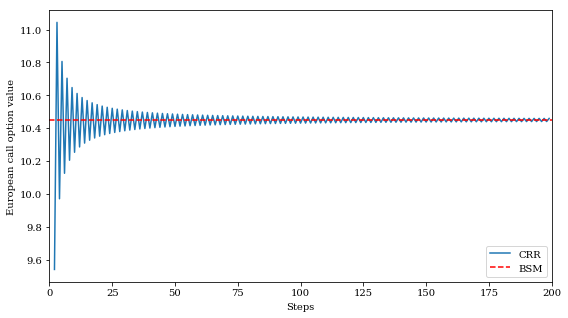

In [8]:
BSM_benchmark = BSM_call_value(S0, K, 0, T, r, sigma)
m = range(mmin, mmax, step_size)
CRR_values = [CRR_european_option_value(S0, K, T, r, sigma, 'call', M) for M in m]
plt.figure(figsize=(9, 5))
plt.plot(m, CRR_values, label='CRR')
plt.axhline(BSM_benchmark, color='r', ls='dashed', lw=1.5,
            label='BSM')
plt.xlabel('Steps')
plt.ylabel('European call option value')
plt.legend(loc=4)
plt.xlim(0, mmax)
plt.show()